# Data set analysis

#### Process the input data

In [1]:
#!pip install pandas
import pandas as pd
import csv

##### Changin the delimiter from ',' to ';'

In [2]:
with open('data.csv', 'r') as input_file, open('data_all.csv', 'w', newline='') as output_file:
    writer = csv.writer(output_file, delimiter=';')
    for line in input_file:
        line = line.strip()
        
        last_comma = line.rfind(',')

        if last_comma != -1:
            row = [line[:last_comma], line[last_comma + 1:]]
            
        writer.writerow(row)

##### Importing the data

In [3]:
data_all = pd.read_csv('data_all.csv', sep=';')
data_all.describe()

,ticket_description,expert_id
count,400,400
unique,40,10
top,Les permissions des rôles d'utilisateur ne fon...,expert_8
freq,16,53


##### Normalizing characters

In [4]:
import unicodedata

def normalize_chars(text):
    if isinstance(text, str):
        normalized = unicodedata.normalize('NFKD', text)
        no_diacritics = ''.join(char for char in normalized if not unicodedata.combining(char))
        return no_diacritics
    return text

data_all['ticket_description'] = data_all['ticket_description'].apply(normalize_chars)

data_all.to_csv('data_all_normalized.csv', sep=';', index=False)

##### Check for null values

In [5]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ticket_description  400 non-null    object
 1   expert_id           400 non-null    object
dtypes: object(2)
memory usage: 6.4+ KB


##### Check testity of values

In [6]:
import re

def check_row(row):
    c1 = len(row['ticket_description'].strip()) > 0
    c2 = bool(re.match(r'^expert_\d+$', row['expert_id']))
    return c1 and c2

data_all_cleaned = data_all[data_all.apply(check_row, axis=1)]

data_all = data_all_cleaned.reset_index(drop=True)

data_all.describe()

,ticket_description,expert_id
count,400,400
unique,40,10
top,Les permissions des roles d'utilisateur ne fon...,expert_8
freq,16,53


##### Change the label type from string to integer

In [7]:
for i,row in data_all.iterrows():
    data_all.at[i, 'expert_id'] = int(data_all.at[i, 'expert_id'].split('_')[1])
data_all.head()

,ticket_description,expert_id
0,Data not syncing with the cloud.,6
1,System reports inaccurate metrics.,4
2,Payment gateway timeout error.,5
3,Permissions issue for user roles.,0
4,Integration with third-party API fails.,5


##### Splitting the data into english and french parts

In [8]:
num_eng = 200

data_eng = data_all.iloc[:num_eng]
data_fr = data_all.iloc[num_eng:]

data_eng.to_csv('data_eng.csv', sep=';', index=False)
data_fr.to_csv('data_fr.csv', sep=';', index=False)

##### Removing the duplicates

In [9]:
data_all = data_all.drop_duplicates()
data_eng = data_eng.drop_duplicates()
data_fr = data_fr.drop_duplicates()
print(data_all.describe())
print(data_eng.describe())
print(data_fr.describe())

                                       ticket_description  expert_id
count                                                 250        250
unique                                                 40         10
top     Le systeme genere des metriques inexactes dans...          8
freq                                                    9         30
                    ticket_description  expert_id
count                              124        124
unique                              20         10
top     Incorrect timezone in reports.          0
freq                                 8         16
                                       ticket_description  expert_id
count                                                 126        126
unique                                                 20         10
top     Le planificateur n'execute pas les taches prog...          8
freq                                                    9         16


#### Analyzing the distribution

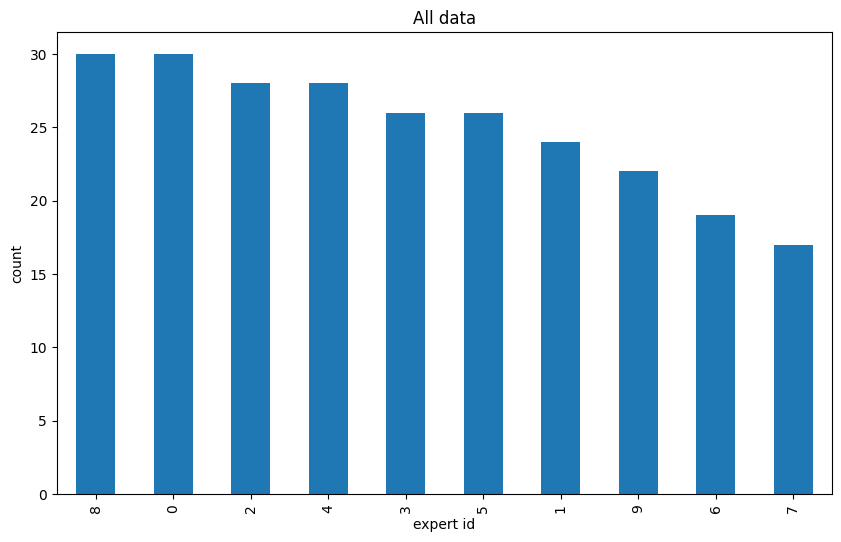

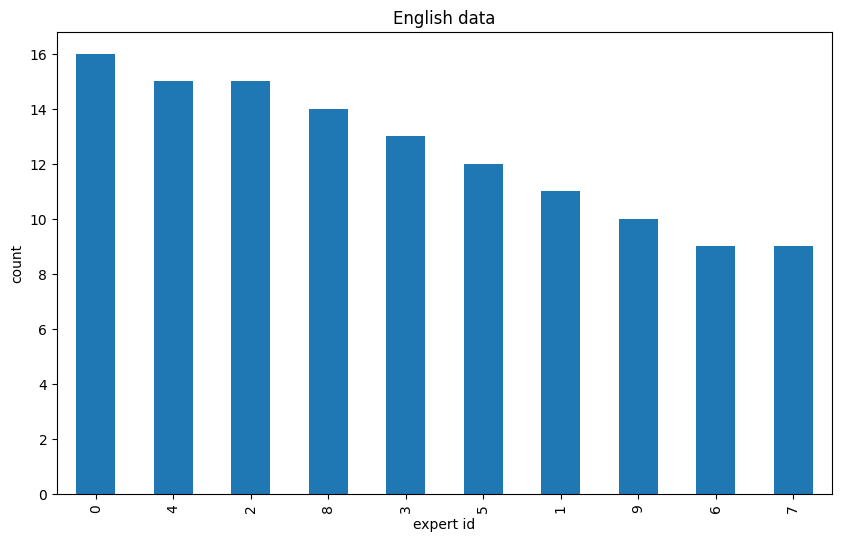

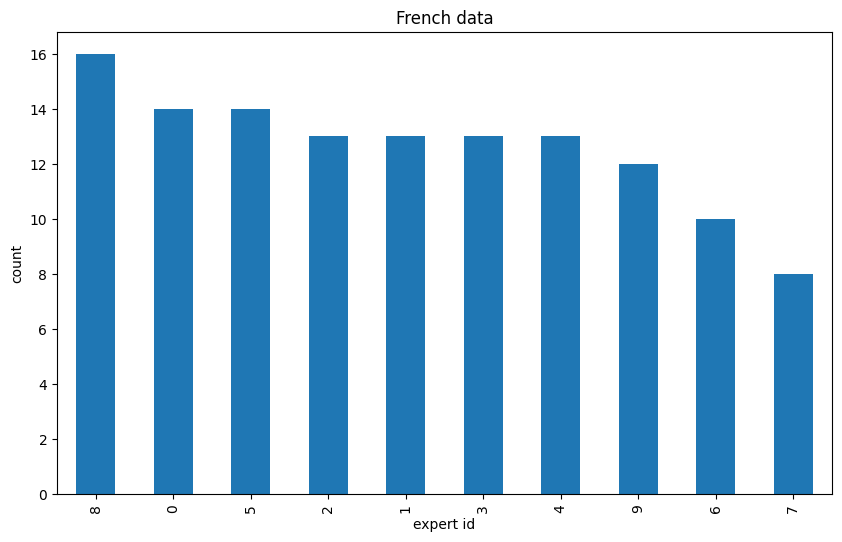

In [10]:
#!pip install matplotlib
import matplotlib.pyplot as plt

distributions = [
    (data_all['expert_id'].value_counts(), 'All data'),
    (data_eng['expert_id'].value_counts(), 'English data'),
    (data_fr['expert_id'].value_counts(), 'French data')
]

for dist, title in distributions:
    dist.plot(kind='bar', figsize=(10, 6))
    plt.title(title)
    plt.xlabel('expert id')
    plt.ylabel('count')
    plt.show()

##### Class imbalance is more present in the french data, but all together, there is no significance class imbalance

# Base model: Bayes classification

#### Split the data into train and test

In [11]:
import random
import numpy as np

def assign_train_test_split(df, train_ratio=0.8, random_seed=None):
    df1 = df.copy()
    shuffled_df = df1.sample(frac=1, random_state=random_seed).reset_index(drop=True)
    train_size = int(len(shuffled_df) * train_ratio)
    shuffled_df['split'] = ['train'] * train_size + ['test'] * (len(shuffled_df) - train_size)
    final_df = shuffled_df.sample(frac=1, random_state=random_seed).reset_index(drop=True)
    return final_df
    
data_all = assign_train_test_split(data_all, random_seed=1)
data_eng = assign_train_test_split(data_eng, random_seed=1)
data_fr = assign_train_test_split(data_fr, random_seed=1)

In [12]:
print(data_all.value_counts('split', normalize=True))
print(data_eng.value_counts('split', normalize=True))
print(data_fr.value_counts('split', normalize=True))

split
train    0.8
test     0.2
Name: proportion, dtype: float64
split
train    0.798387
test     0.201613
Name: proportion, dtype: float64
split
train    0.793651
test     0.206349
Name: proportion, dtype: float64


In [13]:
#!pip install scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [14]:
def get_tfidf_vectors_and_labels(df, split="train", vectorizer=None):
    if vectorizer is None:
        vectorizer = TfidfVectorizer(max_features=100)
    if split == "train":
        vectorizer.fit(df[df.split == split]['ticket_description'])
    vectors = vectorizer.transform(df[df.split == split]['ticket_description'])
    labels = df[df.split == split]['expert_id']#.to_numpy(dtype=int)
    return vectors.toarray(), labels.to_numpy(dtype=int), vectorizer

def do_tfidf_prediction(df, max_features, model='nb'):
    vectorizer = TfidfVectorizer(max_features=max_features)
    vectors_train, labels_train, vectorizer = get_tfidf_vectors_and_labels(df, split="train", vectorizer=vectorizer)
    vectors_test, labels_test, _ = get_tfidf_vectors_and_labels(df, split="test", vectorizer=vectorizer)
    
    if model == 'nb':
        classifier = MultinomialNB().fit(vectors_train, labels_train)
    else:
        classifier = LogisticRegression().fit(vectors_train, labels_train)
    
    predicted_train = classifier.predict(vectors_train)
    predicted_test = classifier.predict(vectors_test)
    f1_train = f1_score(labels_train, predicted_train, average='macro')
    f1_test = f1_score(labels_test, predicted_test, average='macro')
    accuracy = (predicted_test == labels_test).sum() / len(predicted_test)
    return f1_train, f1_test, accuracy

In [15]:
from sklearn.metrics import f1_score, classification_report

def do_tfidf_prediction(df, max_features, model='nb'):
    vectorizer = TfidfVectorizer(max_features=max_features)
    vectors_train, labels_train, vectorizer = get_tfidf_vectors_and_labels(df, split="train", vectorizer=vectorizer)
    vectors_test, labels_test, _ = get_tfidf_vectors_and_labels(df, split="test", vectorizer=vectorizer)
    
    # Train the chosen classifier
    if model == 'nb':
        classifier = MultinomialNB().fit(vectors_train, labels_train)
    else:
        classifier = LogisticRegression().fit(vectors_train, labels_train)
    
    # Predictions
    predicted_train = classifier.predict(vectors_train)
    predicted_test = classifier.predict(vectors_test)
    
    # Overall F1 Scores
    f1_train = f1_score(labels_train, predicted_train, average='macro')
    f1_test = f1_score(labels_test, predicted_test, average='macro')
    
    # Per-Class F1 Scores with zero_division set to avoid warnings
    class_f1_scores = classification_report(labels_test, predicted_test, output_dict=True, zero_division=0)
    f1_per_class = [(class_name, metrics['f1-score']) for class_name, metrics in class_f1_scores.items() if isinstance(metrics, dict) and 'f1-score' in metrics]
    
    return f1_train, f1_test, f1_per_class


from sklearn.metrics import f1_score, classification_report

def do_tfidf_prediction(df, max_features, model='nb'):
    vectorizer = TfidfVectorizer(max_features=max_features)
    vectors_train, labels_train, vectorizer = get_tfidf_vectors_and_labels(df, split="train", vectorizer=vectorizer)
    vectors_test, labels_test, _ = get_tfidf_vectors_and_labels(df, split="test", vectorizer=vectorizer)
    
    # Convert labels_test to numpy array and ensure it's clean
    labels_test = labels_test.to_numpy().astype(str)
    
    # Train the chosen classifier
    if model == 'nb':
        classifier = MultinomialNB().fit(vectors_train, labels_train)
    else:
        classifier = LogisticRegression().fit(vectors_train, labels_train)
    
    # Predictions
    predicted_test = classifier.predict(vectors_test).astype(str)

    print(f"LABEL TEST, type: {type(labels_test)}")
    print(labels_test)
    print(f"PREDICTED TEST, type: {type(predicted_test)}")
    print(predicted_test)

    all_labels = sorted(np.unique(labels_test))
    
    # Debugging: Print unique values
    print("Unique True Labels:", np.unique(labels_test))
    print("Unique Predicted Labels:", np.unique(predicted_test))
    
    # Overall F1 Scores
    f1_train = f1_score(labels_train, classifier.predict(vectors_train), average='macro')
    f1_test = f1_score(labels_test, predicted_test, average='macro')
    
    # Classification Report
    class_f1_scores = classification_report(labels_test, predicted_test, labels=all_labels, output_dict=True, zero_division=0)
    f1_per_class = [(class_name, metrics['f1-score']) for class_name, metrics in class_f1_scores.items() if isinstance(metrics, dict) and 'f1-score' in metrics]

    print(class_f1_scores)
    
    return f1_train, f1_test, f1_per_class


In [16]:
f1_train, f1_test, accuracy = do_tfidf_prediction(data_all, max_features = 10)
f1_train, f1_test, accuracy

(np.float64(0.09725385907951697),
 np.float64(0.014285714285714285),
 [('0', 0.14285714285714285),
  ('1', 0.0),
  ('2', 0.0),
  ('3', 0.0),
  ('4', 0.0),
  ('5', 0.0),
  ('6', 0.0),
  ('7', 0.0),
  ('8', 0.0),
  ('9', 0.0),
  ('macro avg', 0.014285714285714285),
  ('weighted avg', 0.011428571428571429)])

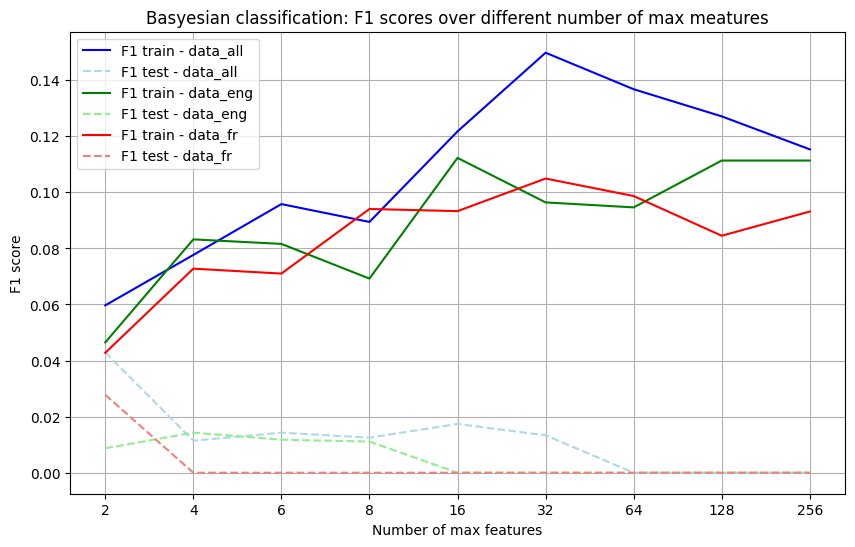

In [17]:
datasets = {
    "data_all": data_all,
    "data_eng": data_eng,
    "data_fr": data_fr
}

colors = {
    "data_all": ("blue", "lightblue"),
    "data_eng": ("green", "lightgreen"),
    "data_fr": ("red", "lightcoral")
}

max_features_list = [2, 4, 6, 8, 16, 32, 64, 128, 256]

plt.figure(figsize=(10, 6))

for dataset_name, dataset in datasets.items():
    f1_scores_train = []
    f1_scores_test = []
    for max_features in max_features_list:
        f1_train, f1_test, acc = do_tfidf_prediction(dataset, max_features=max_features)
        f1_scores_train.append(f1_train)
        f1_scores_test.append(f1_test)
    
    plt.plot(
        np.arange(len(max_features_list)),
        f1_scores_train,
        label=f"F1 train - {dataset_name}",
        color=colors[dataset_name][0]
    )
    plt.plot(
        np.arange(len(max_features_list)),
        f1_scores_test,
        label=f"F1 test - {dataset_name}",
        color=colors[dataset_name][1],
        linestyle="dashed"
    )

plt.xticks(np.arange(len(max_features_list)), max_features_list)
plt.xlabel("Number of max features")
plt.ylabel("F1 score")
plt.title("Basyesian classification: F1 scores over different number of max meatures")
plt.legend()
plt.grid(True)

plt.show()


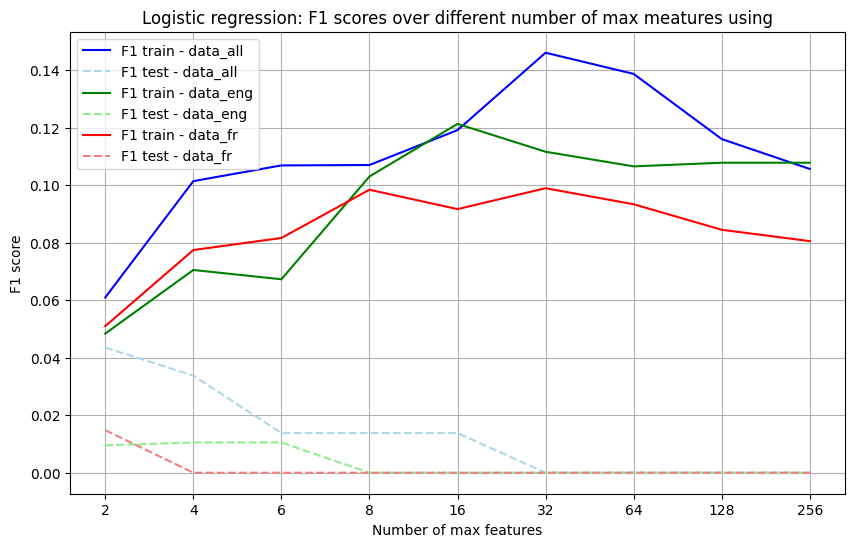

In [18]:
datasets = {
    "data_all": data_all,
    "data_eng": data_eng,
    "data_fr": data_fr
}

colors = {
    "data_all": ("blue", "lightblue"),
    "data_eng": ("green", "lightgreen"),
    "data_fr": ("red", "lightcoral")
}

max_features_list = [2, 4, 6, 8, 16, 32, 64, 128, 256]

plt.figure(figsize=(10, 6))

for dataset_name, dataset in datasets.items():
    f1_scores_train = []
    f1_scores_test = []
    for max_features in max_features_list:
        f1_train, f1_test, acc = do_tfidf_prediction(dataset, max_features=max_features, model='logistic')
        f1_scores_train.append(f1_train)
        f1_scores_test.append(f1_test)
    
    plt.plot(
        np.arange(len(max_features_list)),
        f1_scores_train,
        label=f"F1 train - {dataset_name}",
        color=colors[dataset_name][0]
    )
    plt.plot(
        np.arange(len(max_features_list)),
        f1_scores_test,
        label=f"F1 test - {dataset_name}",
        color=colors[dataset_name][1],
        linestyle="dashed"
    )

plt.xticks(np.arange(len(max_features_list)), max_features_list)
plt.xlabel("Number of max features")
plt.ylabel("F1 score")
plt.title("Logistic regression: F1 scores over different number of max meatures using")
plt.legend()
plt.grid(True)

plt.show()


In [19]:
data_all.describe()

,ticket_description,expert_id,split
count,250,250,250
unique,40,10,2
top,Le planificateur n'execute pas les taches prog...,8,train
freq,9,30,200


In [20]:
f1_train, f1_test, f1_per_class = do_tfidf_prediction(data_all, max_features = 16)
f1_train, f1_test, f1_per_class

(np.float64(0.12172662823961014),
 np.float64(0.017391304347826087),
 [('0', 0.17391304347826086),
  ('1', 0.0),
  ('2', 0.0),
  ('3', 0.0),
  ('4', 0.0),
  ('5', 0.0),
  ('6', 0.0),
  ('7', 0.0),
  ('8', 0.0),
  ('9', 0.0),
  ('macro avg', 0.017391304347826087),
  ('weighted avg', 0.013913043478260868)])

##### Conclusion: The dataset is too small to produce high quality results using traditional machine learning methods such as Naive Bayes and Logistic Regression with TF-IDF. The limited data size leads to overfitting on the training set, and poor generalization on the test set. The results are generally poor and similar, with French dataset performing the worst, with slightly better and similar results for combined and English only dataset. 

##### Even though logistic regression should generally perform better than Naive Bayes, here it is not the case. Possibly because they share the same TF-IDF features, which are sparse because the sentances are short and contain a small number of all features. This can be seen on the plot, as test perfomance lowers with the increased numbers of max features. The logistic regression would possibly achieve better performance if we had more input data.

# First model: BERT

In [79]:

x_train = data_all[data_all.split=='train']['ticket_description'].values
y_train = data_all[data_all.split=='train']['expert_id'].values
x_test = data_all[data_all.split=='test']['ticket_description'].values
y_test = data_all[data_all.split=='test']['expert_id'].values
"""
x_train = data_eng[data_eng.split=='train']['ticket_description'].values
y_train = data_eng[data_eng.split=='train']['expert_id'].values
x_test = data_eng[data_eng.split=='test']['ticket_description'].values
y_test = data_eng[data_eng.split=='test']['expert_id'].values
"""

In [80]:
x_train[0]

'System crashes when loading files.'

In [81]:
x_train[0]

'System crashes when loading files.'

In [82]:
np.concatenate((x_train, y_train))[0]

'System crashes when loading files.'

In [83]:
#!pip install transformers
from transformers import DistilBertTokenizer

MAX_LEN = 0

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', padding=True, truncation=True)

print(type(x_train))

all_data = np.concatenate((x_train, x_test, y_train, y_test))

# let's check out how the tokenizer works
for i in range(3):
    if len(tokenizer(all_data[i])['input_ids']) > MAX_LEN:
        MAX_LEN = len(tokenizer(all_data[i])['input_ids'])
    if i == 0:
        # tokenize sentences
        tokenizer_out = tokenizer(all_data[i])
        # convert numerical tokens to alphabetical tokens
        encoded_tok = tokenizer.convert_ids_to_tokens(tokenizer_out.input_ids)
        # decode tokens back to string
        decoded = tokenizer.decode(tokenizer_out.input_ids)
        print(tokenizer_out)
        print('\n')
        print(encoded_tok, '\n')
        print('\n')
        print(decoded, '\n')
        print('\n')
        print('---------------- \n')

MAX_LEN

<class 'numpy.ndarray'>
{'input_ids': [101, 2291, 19119, 2043, 10578, 6764, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


['[CLS]', 'system', 'crashes', 'when', 'loading', 'files', '.', '[SEP]'] 



[CLS] system crashes when loading files. [SEP] 



---------------- 



9

In [84]:
#!C:\Users\David\AppData\Local\Programs\Python\Python311\python.exe -m pip install ipykernel
#!C:\Users\David\AppData\Local\Programs\Python\Python311\python.exe -m ipykernel install --user --name python311 --display-name "Python 3.11 (torch)"

In [85]:
!pip show torch
!python --version
import sys
print(sys.executable)

Name: torch
Version: 2.5.1
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: C:\Users\David\AppData\Local\Programs\Python\Python311\Lib\site-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: accelerate, torchaudio, torchvision
Python 3.11.0
C:\Users\David\AppData\Local\Programs\Python\Python311\python.exe


##### Creating the custom dataset

In [86]:
#!pip3 install torch torchvision torchaudio
import torch
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, item):
        # select the sentence and its class
        sentence = str(self.sentences[item])
        label = self.labels[item]
        # tokenize the sencence
        tokenizer_out = self.tokenizer(
            sentence,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
            )
        # return a dictionary with the output of the tokenizer and the label
        return  {
            'input_ids': tokenizer_out['input_ids'].flatten(),
            'attention_mask': tokenizer_out['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

train_dataset = MyDataset(x_train, y_train, tokenizer, MAX_LEN)
test_dataset = MyDataset(x_test, y_test, tokenizer, MAX_LEN)

In [87]:
train_dataset[0]

{'input_ids': tensor([  101,  2291, 19119,  2043, 10578,  6764,  1012,   102,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0]),
 'label': tensor(1)}

##### Importing the model

In [88]:
from transformers import DistilBertModel

PRE_TRAINED_MODEL_NAME = 'distilbert-base-uncased'

distil_bert = DistilBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
distil_bert

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

##### Inspect the output shape of the model

In [89]:
first_sample = train_dataset[0]
hidden_state = distil_bert(first_sample['input_ids'].unsqueeze(0), attention_mask=first_sample['attention_mask'].unsqueeze(0))
hidden_state[0].shape

torch.Size([1, 9, 768])

##### Building the classifier

from transformers import DistilBertPreTrainedModel

FREEZE = True

class DistilBertClassifier(DistilBertPreTrainedModel):
    def __init__(self, config, num_labels, freeze=False):
        super.__init__(config)
        self.num_labels = num_labels
        self.encoder = DistilBertModel.from_pretrained(MODEL_NAME)
        if freeze:
            for param in self.encoder.parameters():
                param.requires_grad = False
        self.classifier = torch.nn.Linear(
            in_features = config.dim,
            out_features = self.num_labels,
            bias=True
        )
        self.dropout = torch.nn.Dropout(p=-0.1)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
    ):
        encoder_output = self.encoder(
            input_ids = input_ids,
            attention_mask = attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            labels=labels,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
        )

        hidden_state = encoder_output[0]
        pooled_output = hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + encoder_output[1:]

        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits, labels)
            outputs = (loss,) + outputs
            
        outputs = (loss,) + outputs
    
    return outputs
    
classes = data_all.expert_id.unique()

model = DistilBertClassifier(
    config=distil_bert.configm,
    num_labels = len(classes),
    freeze = FREEZE
)

In [90]:
from transformers import DistilBertPreTrainedModel, DistilBertConfig


PRE_TRAINED_MODEL_NAME = 'distilbert-base-uncased'
FREEZE_PRETRAINED_MODEL = True

class DistilBertForSentimentClassification(DistilBertPreTrainedModel):
    def __init__(self, config, num_labels, freeze_encoder=False):
        # instantiate the parent class DistilBertPreTrainedModel
        super().__init__(config)
        # instantiate num. of classes
        self.num_labels = num_labels
        # instantiate and load a pretrained DistilBERT model as encoder
        self.encoder = DistilBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        # [Q1] freeze the encoder parameters if required
        if freeze_encoder:
          for param in self.encoder.parameters():
              param.requires_grad = False
        # the classifier: a feed-forward layer attached to the encoder's head
        self.classifier = torch.nn.Linear(
            in_features=config.dim, out_features=self.num_labels, bias=True)
        # instantiate a dropout function for the classifier's input
        self.dropout = torch.nn.Dropout(p=0.1)


    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
    ):
        # encode a batch of sequences with DistilBERT
        encoder_output = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
        )
        # extract the hidden representations from the encoder output
        hidden_state = encoder_output[0]  # (bs, seq_len, dim)
        # only select the encoding corresponding to the first token
        # of each sequence in the batch [Q2]
        pooled_output = hidden_state[:, 0]  # (bs, dim)
        # apply dropout
        pooled_output = self.dropout(pooled_output)  # (bs, dim)
        # feed into the classifier
        logits = self.classifier(pooled_output)  # (bs, dim)

        outputs = (logits,) + encoder_output[1:]

        if labels is not None:
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

classes = data_all.expert_id.unique().tolist()

# instantiate model
model = DistilBertForSentimentClassification(
    config=distil_bert.config, num_labels=len(classes),
    freeze_encoder = FREEZE_PRETRAINED_MODEL
    )

# print info about model's parameters
total_params = sum(p.numel() for p in model.parameters())
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
trainable_params = sum([np.prod(p.size()) for p in model_parameters])
print('model total params: ', total_params)
print('model trainable params: ', trainable_params)
print('\n', model)

model total params:  66370570
model trainable params:  7690

 DistilBertForSentimentClassification(
  (encoder): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn)

##### Train the model

In [91]:
!rm -r ./logs ./results

rm: cannot remove './logs': No such file or directory


In [92]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    output_dir='./results',
    logging_dir='./logs',
    logging_first_step=True,
    logging_steps=50,
    num_train_epochs=16,
    per_device_train_batch_size=8,
    learning_rate=5e-5,
    weight_decay=0.01
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    compute_metrics=compute_metrics
)

if torch.cuda.is_available():
  print("GPU will be used.")
  device = torch.cuda.current_device()
else:
  print("CPU will be used.")

In [94]:
train_results = trainer.train()

Step,Training Loss
1,2.349500
50,2.291600
100,2.284700
150,2.274400
200,2.277100


In [95]:
test_results = trainer.predict(test_dataset=test_dataset)
"""
#print('Predictions: \n', test_results.predictions)
print('\nAccuracy: ', test_results.metrics['test_accuracy'])
print('Precision: ', test_results.metrics['test_precision'])
print('Recall: ', test_results.metrics['test_recall'])
print('F1: ', test_results.metrics['test_f1']) 
print(classes)
"""

"\n#print('Predictions: \n', test_results.predictions)\nprint('\nAccuracy: ', test_results.metrics['test_accuracy'])\nprint('Precision: ', test_results.metrics['test_precision'])\nprint('Recall: ', test_results.metrics['test_recall'])\nprint('F1: ', test_results.metrics['test_f1']) \nprint(classes)\n"

In [96]:
test_results.metrics

{'test_loss': 2.3411786556243896,
 'test_accuracy': 0.12,
 'test_f1': array([0.18181818, 0.        , 0.        , 0.        , 0.28571429,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 'test_precision': array([0.10526316, 0.        , 0.        , 0.        , 0.25      ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 'test_recall': array([0.66666667, 0.        , 0.        , 0.        , 0.33333333,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 'test_runtime': 0.1174,
 'test_samples_per_second': 212.913,
 'test_steps_per_second': 34.066}

class: 0
f1 score: 0.18181818181818182
precision: 0.10526315789473684
recall: 0.6666666666666666
--------------------------------
class: 1
f1 score: 0.0
precision: 0.0
recall: 0.0
--------------------------------
class: 2
f1 score: 0.0
precision: 0.0
recall: 0.0
--------------------------------
class: 3
f1 score: 0.0
precision: 0.0
recall: 0.0
--------------------------------
class: 4
f1 score: 0.2857142857142857
precision: 0.25
recall: 0.3333333333333333
--------------------------------
class: 5
f1 score: 0.0
precision: 0.0
recall: 0.0
--------------------------------
class: 6
f1 score: 0.0
precision: 0.0
recall: 0.0
--------------------------------
class: 7
f1 score: 0.0
precision: 0.0
recall: 0.0
--------------------------------
class: 8
f1 score: 0.0
precision: 0.0
recall: 0.0
--------------------------------
class: 9
f1 score: 0.0
precision: 0.0
recall: 0.0
--------------------------------


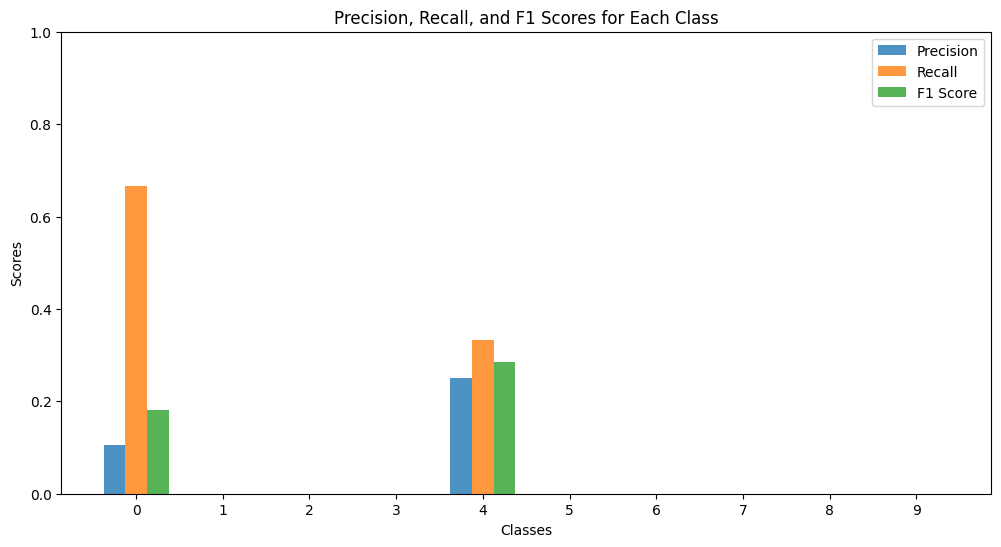

In [98]:
import numpy as np

f1_scores = test_results.metrics["test_f1"]
precision_scores = test_results.metrics["test_precision"]
recall_scores = test_results.metrics["test_recall"]

for i in range(len(f1_scores)):
    print(f'class: {i}')
    print(f'f1 score: {f1_scores[i]}')
    print(f'precision: {precision_scores[i]}')
    print(f'recall: {recall_scores[i]}')
    print('--------------------------------')

x = np.arange(len(f1_scores))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - width, precision_scores, width, label='Precision', alpha=0.8)
plt.bar(x, recall_scores, width, label='Recall', alpha=0.8)
plt.bar(x + width, f1_scores, width, label='F1 Score', alpha=0.8)

plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Precision, Recall, and F1 Scores for Each Class')
plt.ylim(0, 1)
plt.xticks(ticks=x, labels=range(len(f1_scores)))
plt.legend()

plt.show()


In [ ]:
model.config.id2label

In [ ]:
model.config.label2id